# On the role of neurogenesis in overcoming catastrophic forgetting

[=> Link to the paper <=](https://arxiv.org/pdf/1811.02113.pdf)

## Introduction 

State of the art models of machine learning are designed to be used in a 2 step process: learning and inference.

The problem of this paradigma is that these networks are not able to learn in a continuous manner: once the task is learnt, if we want to add some more data, we should retrain the model on the whole dataset. If we don't, we may face some *catastrophic forgetting*, i.e. the model may forget the previous mode of the function he is trying to infer.

To prevent this effect, we may use some dynamic networks, which *grow when required*, as presented by [Marsland et al. (2002)](https://seat.massey.ac.nz/personal/s.r.marsland/PUBS/NN02.pdf)

In this notebook, we will try to demonstrate the ability of those network to learn in a continuous manner. More precisely, we will try to show that growing more neurons when new modes show up is an efficient strategy for that. We will thus compare a static network and a dynamic network to see the influence of growth when required, on the ability of the network to remember precedent features.

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

### MNIST dataset

We work with the MNIST dataset for this notebook. In [the article](https://arxiv.org/pdf/1811.02113.pdf), they used CORe50, but the principle stays the same. It just has to be a classification task.

In [2]:
dataset = load_digits()

In [3]:
X, y = dataset['data']/16, dataset['target']

### Utils

In [4]:
def dist(u,v):
    return np.linalg.norm(u - v, 2)

def add_one_row_and_one_column(matrix):
    temp = np.append(matrix, - np.ones((matrix.shape[0], 1)), axis=1)
    return np.append(temp, - np.ones((1, matrix.shape[0] + 1)), axis=0)

def add_one_row(matrix):
    return np.append(matrix, np.zeros((1, matrix.shape[1])), axis=0)

def add_one_column(matrix):
    return np.append(matrix, np.zeros((matrix.shape[0], 1)), axis=1)

# Text Dynamic self-organizing network

Before understanding the experience in the article, we have to understand a special type of networks : grow-when-required networks

The network we will use here was introduced by [Marsland et al. (2002)](https://seat.massey.ac.nz/personal/s.r.marsland/PUBS/NN02.pdf). It is actually not a classical neural network as we know them (where the output of a layer is the input for the next layer). You could represent it to yourself as a set of "weights" and an algorithm for choosing them. The algorithm is as following (take some time to digest it, it might be a bit harsh to understand at first reading):
- We begin with a set of 2 "neurons", and 0 edges. Each neuron is actually just a vector of weights $w_j$, of the same size as the inputs (here (64,1)).
- Given a new training input $x_i$, we consider the 2 closest neurons $w_b$ (best) and $w_s$ (second best) in term of euclidian distance (the neurons minimizing $||x_i - w_j||^2$). We create an edge between these 2 neurons.
- We compute the activity of the best neuron: $a = exp(-\alpha||x_i - w_b||^2)$. The higher the activity, the closer the neuron is to input.
- 2 possibilities here. Either the activity of the neuron is too low, and its habituation is too low too (we'll speak later about habituation). Then, we create a new neuron to better represent in the input. In the other case, we consider this neuron to be the best representation of the input, and we train it to be even closer.

- IF WE CREATE A NEW NEURON:
    - We first remove the link between the 2 best neurons ($w_b$ and $w_s$) if there is any
    - We set the weight of the new neuron to be $\frac{w_b + x_i}{2}$
    - We create edges between the new neuron and the 2 best neurons


- IF WE DON'T CREATE ANY NEW NEURON:
     - We update the weights of the best neuron and its neighboors according to the following equations 
     
     $\Delta w_b = \epsilon_b * h_b * (x_i - w_b)$
     
     $\Delta w_n = \epsilon_n * h_n * (x_i - w_n)$

    where $\epsilon_b$ and $\epsilon_n$ are fixed learning rates for respectively the best neuron and its neighboors, and $h_b$ and $h_n$ are the     habituation values for them.
    
  - We update the habituation values for the best neuron and its neighboors according ot the following equations
    
    $\Delta h_b = \tau_b * \kappa * (1 - h_b) - \tau_b$
    
    $\Delta h_n = \tau_n * \kappa * (1 - h_n) - \tau_n$
    
    where $\tau_b$, $\tau_n$ and $\kappa$ are constant hyperparameters, controling the decreasing behavior of h. Typically, $\tau_b > \tau_n$ since the habituation should decrease faster for the best neuron than for its neighboors. 
    

### Text summary of the algorithm

The above algorithm can be a bit harsh to understand. Let's try to explain a bit more the process in action.
The network begins with a very small size (2 neurons, 0 edges), and grow over time. For each new entry, we first compute the closest neurons. And then, the algorithm must make a choice: "Is the closest neuron good enough for this entry?". 

To answer this question, it uses 2 metrics. The first one is the activation. It simply tells how close to the entry the best neuron is (if a = 1, then $w_b = x_i$, and when $w_b$ is at an infinite distance from $x_i$, a = 0). 

The second metric is the habituation. This metrics tells how many times the bets neuron was trained. When h is near 1, the neuron is almost new, it wasn't trained a lot. When h is low, the neuron is already old, it was trained a lot of times. This habituation factor is important to give the neuron a chance to get better, before creating a new one. And it also is a warranty than old neurons won't forget what they learned, because theyr learning rate is moduled by their habituation. 

So to sum up a little bit, if the activation of the best neuron is too low, and habituation is low, then we create a new neuron.
Else (either activation is high -> the neuron is good for this entry, or habituation is high -> the neuron is young), we don't create any new neuron. 

### A last thing : inference

So, we know how our network is training, but we still don't know how it is infering ?!?

It is actually a simple majority vote for the inference part. At training time, each time a neuron is chosen for an entry, we associate the label of the entry with this neuron. At inference time, we will just chose the best neuron for the input, and output the most represented class for this neuron. 

Side note: the positive aspect with this method is that we can do it with an not fixed number of classes.

### Are you still there ?

In [5]:
print('I am still there')

I am still there


Great, since you are here, let's experiment !

# Let's just jump into it

So, now that we know the algorithm for dynamic grow-when-required networks, we can get to the point of our article (oof!). The point of the article is to say that it is better to have a little net which will grow, than a big one which is static.

### Hyperparameters 

In [6]:
activity_threshold = 0.7  # Adapted for this experiment
h_threshold = 0.3  # Adapted for this experiment
best_node_learning_rate = 0.5  # Used in the paper
neighboors_nodes_learning_rate = 0.005  # Used in the paper
h0 = 1  # Used in the paper
alpha = 0.67  # Used in the paper
tau_best = 0.01  # Adapted for this experiment
tau_neighboors = 0.003  # Adapted for this experiment
kappa = 1.05  # Used in the paper

### The algorithm

You'll find behind an implementation of the algorithm described above. Read it if you want, bu it is only the code for what you just read.

In [7]:
def train_and_infer(X, y, initial_nodes, initial_edges, max_node_counter):
    """
    Train a grow-when-required network on the (X, y) data.
    Inference is made simultaneously. It is not unfair since the inference part is made before the training part.
    And it allow us to have only a training set (no test set), which is great.
    """
    
    # Initialize our network
    nodes = initial_nodes
    edges = initial_edges
    n = len(nodes)
    h = [h0 for i in range(n)]
    labels_matrix = np.zeros(shape=(n,0))
    known_labels = []
    predictions = []

    for k in range(len(X)):

        current_x = X[k]
        current_y = y[k]
        
        # Add the label to list of known labels.
        if current_y not in known_labels:
            known_labels.append(current_y)
            labels_matrix = add_one_column(labels_matrix)    

        # 1 - Find best node s and second best node t
        best_distance = 64
        second_best_distance = 64
        best_node_index = -1
        second_best_node_index = -1
        for index, node in enumerate(nodes):
            if dist(current_x, node) < second_best_distance:
                if dist(current_x, node) < best_distance:
                    second_best_node_index = best_node_index
                    best_node_index = index
                    second_best_distance = best_distance
                    best_distance = dist(current_x, node)
                else:
                    second_best_node_index = index
                    second_best_distance = dist(current_x, node)

        # Bonus prediction step - make a prediction before training phase
        pred = known_labels[np.argmax(labels_matrix[best_node_index,:])]
        predictions.append(pred)

        # 2 - Add an edge between s and t
        edges[best_node_index, second_best_node_index] = 1
        edges[second_best_node_index, best_node_index] = 1

        # 3 - Compute activity of the best matching unit
        activity = np.exp(- alpha * dist(current_x, nodes[best_node_index]))

        # 4 - If activity too low, firing counter too low, and len(nodes) < max_node_counter, add a new node
        if activity < activity_threshold and h[best_node_index] < h_threshold and len(nodes) < max_node_counter:
            node = (current_x + nodes[best_node_index]) / 2
            nodes.append(node)
            edges = add_one_row_and_one_column(edges)
            labels_matrix = add_one_row(labels_matrix)
            labels_matrix[len(nodes) - 1, known_labels.index(current_y)] += 1
            h.append(h0)

            # add edges between new node and 2 best nodes. Rem¶ove edge between 2 best nodes
            new_node_index = len(nodes) - 1
            edges[new_node_index, best_node_index] = 1
            edges[best_node_index, new_node_index] = 1
            edges[new_node_index, second_best_node_index] = 1
            edges[second_best_node_index, new_node_index] = 1
            edges[best_node_index, second_best_node_index] = 0
            edges[second_best_node_index, best_node_index] = 0

        # Else, take the best node activation as output
        else:
            labels_matrix[best_node_index, known_labels.index(current_y)] += 1

            # 5 - update the weight of the best node, and his neighboors
            nodes[best_node_index] += best_node_learning_rate * h[best_node_index] * (current_x - nodes[best_node_index])
            for i in range(len(nodes)):
                if edges[i, best_node_index] != 0:
                    nodes[i] += neighboors_nodes_learning_rate * h[i] * (current_x - nodes[i])

            # 6 - Update h, the habituation, for the best node and his neighboors
            h[best_node_index] += tau_best * kappa * (1 - h[best_node_index]) - tau_best
            for i in range(len(nodes)):
                if edges[i, best_node_index] != 0:
                    h[i] += tau_neighboors * kappa * (1 - h[i]) - tau_neighboors
        #print(h[best_node_index])
    
    return predictions, len(nodes)

## Experiment: accuracy challenge for 1 to 10 classes

In the experiment, we will compare the performance of a static network (with a fixed number of nodes) and a dynamic one (with increasing number of nodes).

In [9]:
max_nodes_number = 200

In [12]:
static_accuracies = []
dynamic_accuracies = []
static_node_counter = []
dynamic_node_counter = []
static_accuracies_var = []
dynamic_accuracies_var = []
static_node_counter_var = []
dynamic_node_counter_var = []

for k in range(1,11):
    print(f"iteration {k} / 10")
    cur_static_accuracy = []
    cur_static_node_counter = []
    cur_dynamic_accuracy = []
    cur_dynamic_node_counter = []
    for _ in range(10):  # Repetition of the experiment to get more precise results
        classes = np.random.choice([i for i in range(10)], k, replace=False)
        to_take = [True if yi in classes else False for yi in y]
        cur_X = X[to_take]
        cur_y = y[to_take]
        
        # static net
        nodes = [np.random.rand(64) for i in range(max_nodes_number)]
        edges =  np.zeros((max_nodes_number,max_nodes_number))
        preds, node_count = train_and_infer(cur_X, cur_y, nodes, edges, max_nodes_number)
        accuracy = accuracy_score(cur_y, preds)
        cur_static_accuracy.append(accuracy)
        cur_static_node_counter.append(node_count)
        
        # dynamic net
        nodes = [np.random.rand(64) for i in range(2)]
        edges =  np.zeros((2,2))
        preds, node_count = train_and_infer(cur_X, cur_y, nodes, edges, max_nodes_number)
        accuracy = accuracy_score(cur_y, preds)
        cur_dynamic_accuracy.append(accuracy)
        cur_dynamic_node_counter.append(node_count)
    
    static_accuracies.append(np.mean(cur_static_accuracy))
    dynamic_accuracies.append(np.mean(cur_dynamic_accuracy))
    static_node_counter.append(np.mean(cur_static_node_counter))
    dynamic_node_counter.append(np.mean(cur_dynamic_node_counter))
    static_accuracies_var.append(np.var(cur_static_accuracy))
    dynamic_accuracies_var.append(np.var(cur_dynamic_accuracy))
    static_node_counter_var.append(np.var(cur_static_node_counter))
    dynamic_node_counter_var.append(np.var(cur_dynamic_node_counter))

iteration 1 / 10
iteration 2 / 10
iteration 3 / 10
iteration 4 / 10
iteration 5 / 10
iteration 6 / 10
iteration 7 / 10
iteration 8 / 10
iteration 9 / 10
iteration 10 / 10


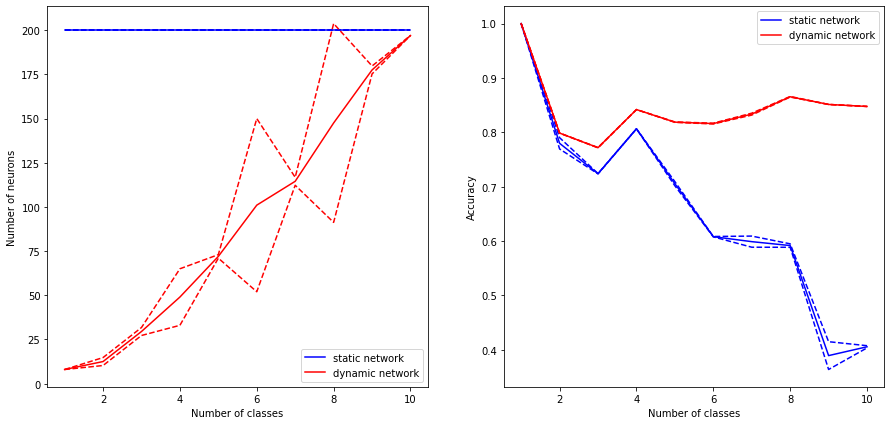

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].plot(np.arange(1, 11), static_node_counter, "b-", label="static network")
ax[0].plot(np.arange(1, 11), np.array(static_node_counter) + np.array(static_node_counter_var), "b--")
ax[0].plot(np.arange(1, 11), np.array(static_node_counter) - np.array(static_node_counter_var), "b--")

ax[0].plot(np.arange(1, 11), dynamic_node_counter, "r-", label="dynamic network")
ax[0].plot(np.arange(1, 11), np.array(dynamic_node_counter) + np.array(dynamic_node_counter_var), "r--")
ax[0].plot(np.arange(1, 11), np.array(dynamic_node_counter) - np.array(dynamic_node_counter_var), "r--")

ax[0].set_xlabel('Number of classes')
ax[0].set_ylabel('Number of neurons')

ax[0].legend()

ax[1].plot(np.arange(1, 11), static_accuracies, "b-", label="static network")
ax[1].plot(np.arange(1, 11), np.array(static_accuracies) + np.array(static_accuracies_var), "b--")
ax[1].plot(np.arange(1, 11), np.array(static_accuracies) - np.array(static_accuracies_var), "b--")

ax[1].plot(np.arange(1, 11), dynamic_accuracies, "r-", label="dynamic network")
ax[1].plot(np.arange(1, 11), np.array(dynamic_accuracies) + np.array(dynamic_accuracies_var), "r--")
ax[1].plot(np.arange(1, 11), np.array(dynamic_accuracies) - np.array(dynamic_accuracies_var), "r--")

ax[1].set_xlabel('Number of classes')
ax[1].set_ylabel('Accuracy')

ax[1].legend()

plt.show()

When there are only a few classes, the static model can handle the fight, but when the number of classes becomes too big, the accuracy gap become huge between the static network and the dynamic one. Even when the number of neurons remains lower for the dynamic network.

This proves the point of the article: networks which grow during training phase avoid the problem of catastrophic forgetting

## Conclusion

So this article showed us that it is possible to overcome the problem of catastophic forgetting (even when the memory is bounded, here by the number of available neurons), by using a neural net that grows when required. But they didn't investigate the problem of "dead" neurons and edges (i.e. neurons and edges that are not used anymore, and that should be removed). This should be done to understand how we can allow the algorithm to forget things on an uncatastrophic way.